## 7-3. Portfolio optimization using HHL algorithm
In this section, let us calculate the optimal portfolio (asset allocation) based on the data of past stock price fluctuations, referring to the paper [1].
Portfolio optimization is one of the problems that is expected to be solved faster than before by using the HHL algorithm learned in [section 7-1](7.1_quantum_phase_estimation_detailed.ipynb).
Specifically, this time, we consider the problem of what kind of asset allocation will give the highest return with the lowest risk when investing in stocks of the four GAFA (Google, Apple, Facebook, and Amazon) companies.

### Stock Price Data Acquisition
First, we obtain the stock price data of each company.

* Use daily data of GAFA 4 companies
* To obtain stock price data, use pandas_datareader to obtain from Yahoo! Finance database.
* Adjusted closing price in dollars (Adj. Close) is used for the stock price.

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
yf.pdr_override()
y_symbols = ['GOOG', 'AAPL', 'META', 'AMZN']

startdate = datetime(2021,1,1)
enddate = datetime(2021,12,31)
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

df = data['Adj Close'][y_symbols]
df.tail()

[*********************100%%**********************]  4 of 4 completed


,GOOG,AAPL,META,AMZN
Date,,,,
2021-12-23,147.142502,174.518219,335.239990,171.068497
2021-12-27,148.063995,178.527786,346.179993,169.669495
2021-12-28,146.447998,177.498154,346.220001,170.660995
2021-12-29,146.504501,177.587265,342.940002,169.201004
2021-12-30,146.002502,176.419037,344.359985,168.644501


<Axes: xlabel='Date'>

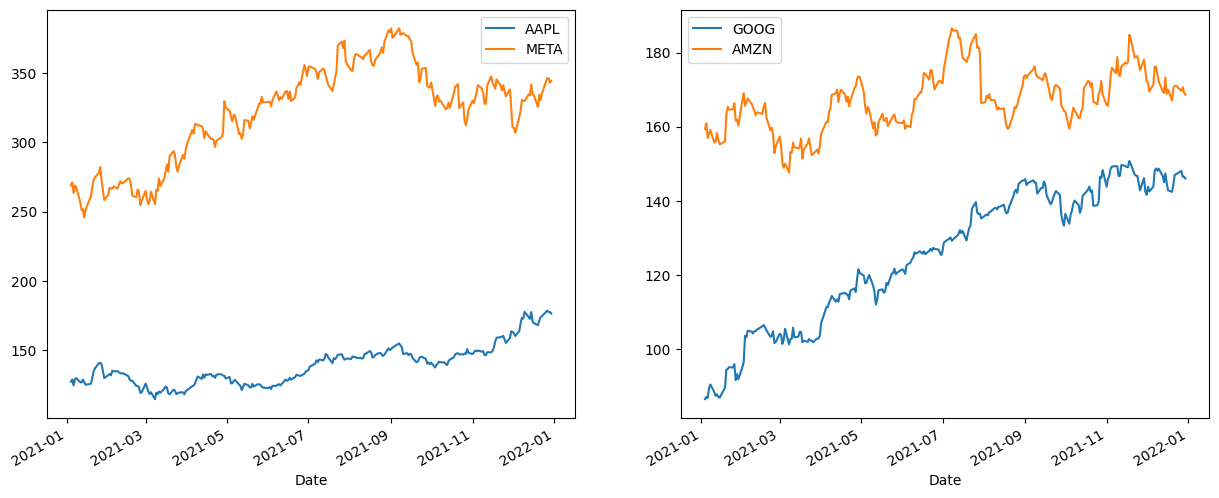

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df.loc[:,['AAPL', 'META']].plot(ax=axes[0])
df.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

*The reason why the four stocks are divided into two groups here is because the stock price values are close to each other and easy to see when plotting, and there is no deeper meaning.

### Data Preprocessing
Next, the acquired stock prices are converted to daily returns to obtain some statistics.

#### Conversion to Daily Returns
The daily return (rate of change) $y_t$ (where $t$ is the date) of an individual stock is defined as follows 

$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

This is obtained with the `pct_change()` method of the `pandas DataFrame`.

In [4]:
daily_return = df.pct_change()
display(daily_return.tail())

,GOOG,AAPL,META,AMZN
Date,,,,
2021-12-23,0.001317,0.003644,0.014495,0.000184
2021-12-27,0.006263,0.022975,0.032633,-0.008178
2021-12-28,-0.010914,-0.005767,0.000116,0.005844
2021-12-29,0.000386,0.000502,-0.009474,-0.008555
2021-12-30,-0.003427,-0.006578,0.004141,-0.003289


In [5]:
df.values

array([[ 86.41200256, 127.33168793, 268.94000244, 159.33149719],
       [ 87.04599762, 128.9059906 , 270.97000122, 160.92550659],
       [ 86.76450348, 124.56681824, 263.30999756, 156.91900635],
       ...,
       [146.44799805, 177.49815369, 346.22000122, 170.66099548],
       [146.50450134, 177.58726501, 342.94000244, 169.20100403],
       [146.00250244, 176.41903687, 344.35998535, 168.64450073]])

#### Expected Returns
Find the expected return $\vec R$ for each stock. Here we use the arithmetic mean of the historical returns: 

$$
\vec R = \frac{1}{T} \sum_{t= 1}^{T} \vec y_t
$$

In [6]:
expected_return = daily_return.dropna(how='all').mean() * 252 # Multiply by 252 annual operating days for annualization
print(expected_return)

GOOG    0.557118
AAPL    0.360158
META    0.292711
AMZN    0.086196
dtype: float64


#### Variance/Covariance Matrix
The sample unbiased variance/covariance matrix $\Sigma$ of the returns is defined by

$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} ( \vec y_t -\vec R ) (\vec y_t -\vec R )^T
$$

In [7]:
cov = daily_return.dropna(how='all').cov() * 252 # For annualized basis
display(cov)

,GOOG,AAPL,META,AMZN
GOOG,0.056299,0.032337,0.039807,0.033450
AAPL,0.032337,0.062804,0.037202,0.035594
META,0.039807,0.037202,0.087240,0.036261
AMZN,0.033450,0.035594,0.036261,0.057891


### Portfolio Optimization
Now that we are ready, let's tackle portfolio optimization.

First, the portfolio (i.e., asset allocation) is represented by a 4-component vector $\vec{w} = (w_0,w_1,w_2,w_3)^T$.
For example, if $\vec{w}=(1,0,0,0)$, it means a portfolio with 100% of its assets invested in Google stock.

Let us consider a portfolio that satisfies the following equation.

$$
\min_{\vec{w}} \frac{1}{2} \vec{w}^T \Sigma \vec{w} \:\:\: \text{s.t.} \:\: \vec R^T \vec w = \mu , \: \vec 1^T \vec w =1
$$

This formula means 

* "minimizing the variance of the portfolio's return"

under the following condition 

* "The expected return (average of returns) of the portfolio is $\mu$"
* "the sum of the weights invested in the portfolio is 1" ($\vec 1 = (1,1,1,1)^T$)

In other words, the best portfolio is the one that minimizes the variance (risk) of the desired future return of only $\mu$ as much as possible. Such a problem setup is called [Markowitz's mean-variance approach](https://en.wikipedia.org/wiki/Modern_portfolio_theory) and is one of the foundational ideas of modern financial engineering.

Using Lagrange's undetermined multiplier method, $\vec{w}$ satisfying the above conditions can be obtained by solving the linear equation

$$
\begin{gather}
W
\left( 
\begin{array}{c}
\eta \\
\theta \\
\vec w
\end{array}
\right)
=
\left( 
\begin{array}{c}
 \mu \\
 1 \\
\vec 0
\end{array}
\right),  \tag{1}\\
W =
\left( 
\begin{array}{ccc}
0 & 0 & \vec R^T \\
0 & 0 & \vec 1^T \\
\vec{R} &\vec 1 & \Sigma 
\end{array}
\right) 
\end{gather}
$$

where $\eta, \theta$ are the parameters of Lagrange's undetermined multiplier method.
Therefore, to find the optimal portfolio $\vec w$, we can solve the simultaneous equation (1) for $\vec w$.
We have now attributed the portfolio optimization problem to a linear equation for which the HHL algorithm can be used.

#### Creating the matrix W

In [8]:
R = expected_return.values
Pi = np.ones(4)
S = cov.values

row1 = np.append(np.zeros(2), R).reshape(1,-1)
row2 = np.append(np.zeros(2), Pi).reshape(1,-1)
row3 = np.concatenate([R.reshape(-1,1), Pi.reshape(-1,1), S], axis=1)
W = np.concatenate([row1, row2, row3])

np.set_printoptions(linewidth=200)
print(W)

[[0.         0.         0.557118   0.3601577  0.29271102 0.08619607]
 [0.         0.         1.         1.         1.         1.        ]
 [0.557118   1.         0.05629903 0.03233694 0.0398072  0.0334504 ]
 [0.3601577  1.         0.03233694 0.06280377 0.03720181 0.03559382]
 [0.29271102 1.         0.0398072  0.03720181 0.08723951 0.03626068]
 [0.08619607 1.         0.0334504  0.03559382 0.03626068 0.05789079]]


In [9]:
expected_return

GOOG    0.557118
AAPL    0.360158
META    0.292711
AMZN    0.086196
dtype: float64

In [10]:
## Check eigenvalue of W -> fits in [-pi, pi]
print(np.linalg.eigh(W)[0])

[-2.0204504  -0.30808313  0.02658232  0.04129316  0.33163183  2.19325933]


#### Creating the right-hand side vector
Given the expected return $\mu$ of the portfolio below, we can calculate the least risky portfolio that will yield such a return. The $\mu$ can be set freely. In general, the higher the expected return, the greater the risk, but we will use 10% as an example (this is a very bearish one, since it is a time when GAFA stocks are going gangbusters).

In [11]:
mu = 0.1 # Portfolio returns (parameters to be put in hand)
xi = 1.0 
mu_xi_0 = np.append(np.array([mu, xi]), np.zeros_like(R)) ## Vector on the right side of equation (1)
print(mu_xi_0)

[0.1 1.  0.  0.  0.  0. ]


#### Extend the matrix so that it can be handled by a quantum system
Since $W$ is 6-dimensional, it is computable in a quantum system with 3 qubits ($2^3 = 8$).
Therefore, we also make a matrix and a vector with the extended two dimensions filled with zeros.

In [12]:
nbit = 3 ## Number of bits used for state
N = 2**nbit

W_enl = np.zeros((N, N)) ## enl stands for enlarged
W_enl[:W.shape[0], :W.shape[1]] = W.copy()
mu_xi_0_enl = np.zeros(N)
mu_xi_0_enl[:len(mu_xi_0)] = mu_xi_0.copy()

We are now ready to solve the simultaneous equation (1).

### Calculating the minimum variance portfolio using the HHL algorithm
Now, let us solve the simultaneous linear equations (1) using the HHL algorithm.
First, as a preliminary step, we prepare the following functions.

* A function `input_state_gate` that returns a quantum circuit that converts the quantum state to $|0\cdots0\rangle \to \sum_i x_i |i \rangle$ according to the classical data $\mathbf{x}$ This function should be built using the qRAM concept, but since we are using a simulator, we will implement it as a non-unitary gate this time. Also, standardization is ignored.)
* Function `CPhaseGate` that returns a control phase gate.
* function `QFT_gate` that returns a gate to perform quantum Fourier transform. 

In [13]:
import numpy as np
from numpy.typing import NDArray
from quri_parts.circuit import QuantumCircuit

def add_CPhaseGate(circuit: QuantumCircuit, control: int, target: int, angle: float) -> None:
    circuit.add_UnitaryMatrix_gate(
        [target],
        np.array([[1, 0], [0, np.exp(1j * angle)]]),
        controlled_on={control: 1}
    )


def add_CUnitaryGate(
    circuit: QuantumCircuit, control: int, target: list[int], unitary_matrix: NDArray[np.complex128]
) -> None:
    circuit.add_UnitaryMatrix_gate(
        target,
        unitary_matrix,
        controlled_on={control: 1}
    )

def add_QFT_gate(
    circuit: QuantumCircuit,
    start_bit: int, end_bit: int, inverse: bool = False
) -> None:
    """ 
    Making a gate which performs quantum Fourier transfromation between start_bit to end_bit.
    (Definition below is the case when start_bit = 0 and end_bit=n-1)
    We associate an integer  j = j_{n-1}...j_0 to quantum state |j_{n-1}...j_0>.
    We define QFT as
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(2pi*i*(k/2^n)*j) |j>.
    then, |k_m > = 1/sqrt(2)*(|0> + exp(i*2pi*0.j_{n-1-m}...j_0)|1> )
    When Inverse=True,  the gate represents Inverse QFT,
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(-2pi*i*(k/2^n)*j) |j>.

    Args:
      int start_bit:  first index of qubits where we apply QFT.
      int end_bit:    last  index of qubits where we apply QFT.
      bool Inverse: When True, the gate perform inverse-QFT ( = QFT^{\dagger}).
    Returns:
      qulacs.QuantumGate: QFT gate which acts on a region between start_bit and end_bit.
    """
    n = end_bit - start_bit + 1

    for target in range(end_bit, start_bit-1, -1):
        circuit.add_H_gate(target)
        for control in range(start_bit, target):
            angle=(-1)**inverse * 2*np.pi / 2**(target-control+1)
            add_CPhaseGate(circuit, control, target, angle)

    for s in range(n//2):
        circuit.add_SWAP_gate(start_bit+s, end_bit-s)


First, set the necessary parameters for the HHL algorithm.
Set the clock register quantum bit number `reg_nbit` to `7` and the coefficient `scale_fac` used for scaling the matrix $W$ to `1` (i.e., do not scale it).
Also, the coefficient $c$ used for the control rotation gate is kept at half of the smallest number of nonzeros that can be represented by the `reg_nbit` bits.

In [14]:
# number of registers used for phase estimation
reg_nbit = 7

## Factor to scale W_enl
scale_fac = 1.
W_enl_scaled = scale_fac * W_enl

## Minimum value to be assumed as an eigenvalue of W_enl_scaled
## In this case, since the projection succeeds 100%, we set the value as a constant multiple of the minimum value that can be represented by the register.
C = 0.5*(2 * np.pi * (1. / 2**(reg_nbit) ))

The core of the HHL algorithm will be written. In this article, we use the simulator qulacs, so various simplifications have been made.
This is an implementation to get a sense of how the HHL algorithm works.

* The part of preparing the input state $|\mathbf{b}\rangle$ is simplified.
* The part of $e^{iA}$ used in the quantum phase estimation algorithm is the diagonalization of $A$ by a classical computer.
* Control rotation gate that takes inverses is also implemented by a classical computer..
* Measure the projection to the auxiliary bit $|0 \rangle{}_{S}$ and treat only the states where the measurement result `0` is obtained.
(For convenience of implementation, the definition of the action of the control rotation gate is reversed from [section 7-1](7.1_quantum_phase_estimation_detailed.ipynb))

In [15]:
from functools import reduce
from quri_parts.qulacs.simulator import run_circuit

D, P = np.linalg.eigh(W_enl_scaled)


#####################################
### Create an HHL quantum circuit. Starting from the 0th bit, 
### we have the bits in the space where A acts (0th ~ nbit-1th), 
### the register bits (nbit th ~ nbit+reg_nbit-1 th), and
### the bits for conditional rotation (nbit+reg_nbit th).
#####################################

total_qubits = nbit + reg_nbit + 1
total_circuit = QuantumCircuit(total_qubits)

## ------ Prepare vector b input to the 0th~(nbit-1)th bit ------
## Normally we should use qRAM algorithm, but here we use our own input gate. 
## In qulacs, you can also implement it with state.load(b_enl).
state = reduce(np.kron, [np.array([[1], [0]]) for _ in range(reg_nbit + 1)] + [mu_xi_0_enl.reshape((2**nbit, 1))]).flatten()

## ------- Hadamard gate on register bit -------
for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
    total_circuit.add_H_gate(register)

## ------- Implement phase estimation -------
## U := e^{i*A*t) and its eigenvalues are diag( {e^{i*2pi*phi_k}}_{k=0, ... N-1)).
## Implement \sum_j |j><j| exp(i*A*t*j) to register bits
for register in range(nbit, nbit+reg_nbit):
    ## Implement U^{2^{register-nbit}}.
    ## Use diagonalized results.
    U_mat = P @ np.diag(np.exp( 1.j * D * (2**(register-nbit)) )) @ P.T.conj()
    add_CUnitaryGate(total_circuit, register, np.arange(nbit), U_mat)

## ------- Perform inverse QFT to register bits -------
add_QFT_gate(total_circuit, nbit, nbit+reg_nbit-1, inverse=True)

## ------- multiply conditional rotation -------
## The eigenvalue of A*t corresponding to the register |phi> is l = 2pi * 0. phi = 2pi * (phi / 2**reg_nbit).
## The definition of conditional rotation is (opposite of the text)
## |phi>|0> -> C/(lambda)|phi>|0> + sqrt(1 - C^2/(lambda)^2)|phi>|1>.
## Since this is a classical simulation, the gate is made explicitly.
condrot_mat = np.zeros( (2**(reg_nbit+1), (2**(reg_nbit+1))), dtype=complex)
for index in range(2**reg_nbit):
    lam = 2 * np.pi * (float(index) / 2**(reg_nbit) )
    index_0 = index ## integer which represents |index>|0>
    index_1 = index + 2**reg_nbit ## integer which represents |index>|1>
    if lam >= C:
        if lam >= np.pi: ## Since we have scaled the eigenvalues in [-pi, pi] beforehand, [pi, 2pi] corresponds to a negative eigenvalue
            lam = lam - 2*np.pi
        condrot_mat[index_0, index_0] = C / lam
        condrot_mat[index_1, index_0] =   np.sqrt( 1 - C**2/lam**2 )
        condrot_mat[index_0, index_1] = - np.sqrt( 1 - C**2/lam**2 )
        condrot_mat[index_1, index_1] = C / lam

    else:
        condrot_mat[index_0, index_0] = 1.
        condrot_mat[index_1, index_1] = 1.

## Convert to DenseGate and implement
total_circuit.add_UnitaryMatrix_gate(np.arange(nbit, nbit+reg_nbit+1), condrot_mat)

## ------- Perform QFT to register bits -------
add_QFT_gate(total_circuit, nbit, nbit+reg_nbit-1, inverse=False)

## ------- Implement the inverse of phase estimation (U^\dagger = e^{-iAt}) -------
for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
    ## implement {U^{\dagger}}^{2^{register-nbit}}
    ## use diagonalized results.
    U_mat = P @ np.diag(np.exp( -1.j* D * (2**(register-nbit)) )) @ P.T.conj()
    add_CUnitaryGate(total_circuit, register, np.arange(nbit), U_mat)

## ------- act Hadamard gate on register bit -------
for register in range(nbit, nbit+reg_nbit): 
    total_circuit.add_H_gate(register)

## ------- Project auxiliary bits to 0. Implemented in qulacs as a non-unitary gate -------
# total_circuit.add_P0_gate(nbit+reg_nbit)

#####################################
### Run the HHL quantum circuit and retrieve the result
#####################################
updated_state = run_circuit(total_circuit, state)
projector = reduce(
    np.kron,
    [
        np.array([[1, 0], [0, 0]]) if i < 1 else np.eye(2)
        for i in range(total_qubits)
    ]
)
final_state = projector @ updated_state

## The 0th to (nbit-1)th bit corresponds to the calculation result |x>.
result = final_state[:2**nbit].real
x_HHL = result/C * scale_fac

Comparing the solution `x_HHL` by the HHL algorithm with the solution `x_exact` by diagonalization of the usual classical computation, we can see that they are roughly in agreement. (There are several parameters that determine the accuracy of the HHL algorithm (e.g. `reg_nbit`), so please try changing them and experiment with them).

In [16]:
## Exact solution
x_exact = np.linalg.lstsq(W_enl, mu_xi_0_enl, rcond=0)[0]

print("HHL:  ", x_HHL)
print("exact:", x_exact)
rel_error = np.linalg.norm(x_HHL- x_exact) / np.linalg.norm(x_exact)
print("rel_error", rel_error)

HHL:   [ 0.05287765 -0.06077207 -0.15911616  0.18428418  0.18792996  0.78573672  0.          0.        ]
exact: [ 0.04871223 -0.05830825 -0.13610431  0.16431654  0.15922337  0.81256439  0.          0.        ]
rel_error 0.058192698854745845


If we take out only the actual weighting part

In [17]:
w_opt_HHL = x_HHL[2:6] 
w_opt_exact = x_exact[2:6]
w_opt = pd.DataFrame(np.vstack([w_opt_exact, w_opt_HHL]).T, index=df.columns, columns=['exact', 'HHL'])
w_opt

,exact,HHL
GOOG,-0.136104,-0.159116
AAPL,0.164317,0.184284
META,0.159223,0.187930
AMZN,0.812564,0.785737


<Axes: >

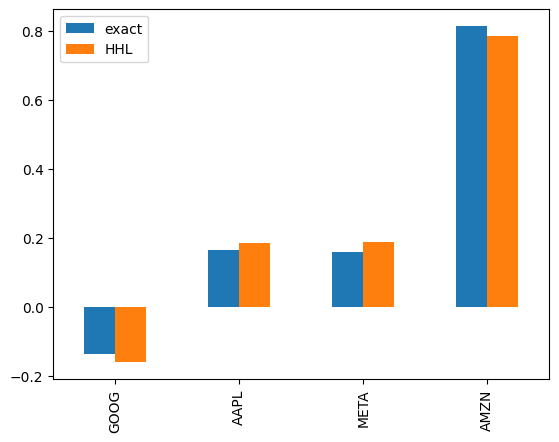

In [18]:
w_opt.plot.bar()

*Stocks with negative weights represent "short selling" (borrowing shares and selling them. It is a technique whereby profits can be made during periods of falling stock prices). In this case, the target return was set at 10%, which is quite small for GAFA stocks (expected return of 30-40% alone), so short selling is likely to have lowered the overall expected return.

### Appendix: Back Testing
The verification of an investment rule derived from historical data using subsequent data is called "back-testing," and is important for measuring the effectiveness of the investment rule.
In this section, we will observe how much asset values change in the following year, 2018, when invested in a portfolio constructed from 2017 data as described above.

In [19]:
yf.pdr_override()
y_symbols = ['GOOG', 'AAPL', 'META', 'AMZN']

startdate = datetime(2022,1,1)
enddate = datetime(2022,12,31)
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

df2022 = data['Adj Close'][y_symbols]
df2022.tail()

[*********************100%%**********************]  4 of 4 completed


,GOOG,AAPL,META,AMZN
Date,,,,
2022-12-23,89.809998,131.299820,118.040001,85.250000
2022-12-27,87.930000,129.477585,116.879997,83.040001
2022-12-28,86.459999,125.504539,115.620003,81.820000
2022-12-29,88.949997,129.059372,120.260002,84.180000
2022-12-30,88.730003,129.378006,120.339996,84.000000


<Axes: xlabel='Date'>

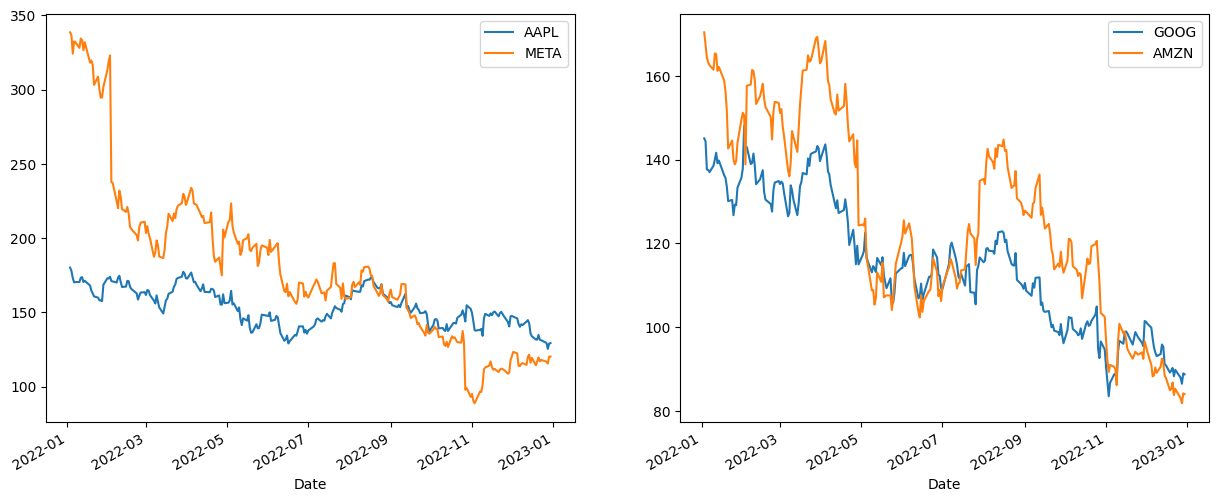

In [20]:
## Plot the stock price
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df2022.loc[:,['AAPL', 'META']].plot(ax=axes[0])
df2022.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

In [21]:
# Changes in portfolio asset values
pf_value = df2022.dot(w_opt)
pf_value.head()

,exact,HHL
Date,,
2022-01-03,202.231202,207.637530
2022-01-04,199.282729,204.678165
2022-01-05,194.885846,200.072516
2022-01-06,194.848493,200.247366
2022-01-07,194.275056,199.689412


In [22]:
# Since the initial amount may differ between exact and HHL, we look at returns normalized by the value at the beginning of the period.
pf_value.exact = pf_value.exact / pf_value.exact[0] 
pf_value.HHL = pf_value.HHL / pf_value.HHL[0] 
print(pf_value.tail())

               exact       HHL
Date                          
2022-12-23  0.481711  0.477147
2022-12-27  0.471703  0.467557
2022-12-28  0.463570  0.459400
2022-12-29  0.477918  0.473778
2022-12-30  0.477665  0.473620


<Axes: xlabel='Date'>

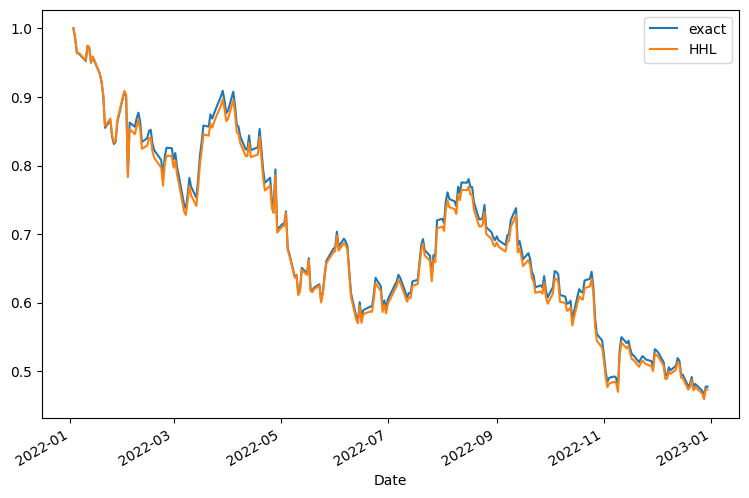

In [23]:
pf_value.plot(figsize=(9, 6))

The stocks of all GAFA companies except Amazon were soft in 2018, resulting in a loss of roughly -20%. The EXACT solution seems to be somewhat better.
Incidentally, since what we originally did was risk minimization, we also calculated the risk for the past year, and the EXACT solution resulted in smaller risk.

In [24]:
pf_value.pct_change().std() * np.sqrt(252) ## annualized

exact    0.472897
HHL      0.472822
dtype: float64

### Reference
[1] P. Rebentrost and S. Lloyd, “Quantum computational finance: quantum algorithm for portfolio optimization“, https://arxiv.org/abs/1811.03975